In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import explained_variance_score, r2_score, make_scorer
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

import optuna

# 1 Preparation

In [2]:
embedding_file = "test/embeddings_complete.pickle"
expression_file = "datasets/GD660.GeneQuantRPKM.txt.gz"
test_set_file = "datasets/5_fold_cv_split.tsv"
snp_reference_file = "datasets/EUR373.gene.cis.FDR5.all.rs137.txt.gz"

## 1.1 Embeddings

In [3]:
embeddings = pd.read_pickle(embedding_file)
len(embeddings)

10060

In [4]:
# combine 2 embeddings of father and mother for each individual
sample_id = []
gene_id = []
embedding = []
for i in range(0, len(embeddings), 2):
    sid = embeddings[i][0].split(':')[1]
    gid = embeddings[i][0].split(':')[2]
    sample_id.append(sid)
    gene_id.append(gid)
    # combined_embedding = np.concatenate([embeddings[i][1], embeddings[i+1][1]]) # concatenate 2 embeddings.
    combined_embedding = np.array(embeddings[i][1] + embeddings[i+1][1]) # element-wise sum of 2 embeddings
    embedding.append(combined_embedding)
df = pd.DataFrame({"sample_id": sample_id, "gene_id": gene_id, "embedding": embedding})

In [5]:
df.head()

,sample_id,gene_id,embedding
0,NA20795,ENSG00000198502.5,"[0.020763932, -0.0043599964, 0.018072195, -0.0..."
1,HG00260,ENSG00000214425.1,"[0.034569502, 0.024124226, -0.06553179, -0.017..."
2,HG01632,ENSG00000176681.9,"[-0.0912664, 0.07260499, -0.07260455, 0.113591..."
3,HG00173,ENSG00000238083.3,"[0.08705197, 0.056551743, 0.033424325, -0.0829..."
4,HG00178,ENSG00000229450.2,"[0.14517619, -0.016366798, -0.0096497275, -0.0..."


## 1.2 Expression Data

In [6]:
expression = pd.read_csv(expression_file, sep="\t")
expression.head()

,TargetID,Gene_Symbol,Chr,Coord,HG00096.1.M_111124_6,HG00097.7.M_120219_2,HG00099.1.M_120209_6,HG00099.5.M_120131_3,HG00100.2.M_111215_8,HG00101.1.M_111124_4,...,NA20810.2.M_111215_7,NA20811.1.M_111124_5,NA20812.2.M_111216_6,NA20813.5.M_120131_1,NA20814.2.M_111215_6,NA20815.5.M_120131_5,NA20816.3.M_120202_7,NA20819.3.M_120202_2,NA20826.1.M_111124_1,NA20828.2.M_111216_8
0,ENSG00000225538.1,ENSG00000225538.1,11,55850277,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.03876,0.00000
1,ENSG00000237851.1,ENSG00000237851.1,6,143109260,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000
2,ENSG00000243765.1,ENSG00000243765.1,15,58442766,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000
3,ENSG00000257527.1,ENSG00000257527.1,16,18505708,0.70561,0.66697,0.64004,0.26195,0.34695,1.49208,...,0.87085,0.9495,0.95837,0.51002,0.29422,0.2296,0.58671,0.27674,0.53630,0.17139
4,ENSG00000212855.5,ENSG00000212855.5,Y,9578193,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000


In [7]:
expression = expression[expression["Gene_Symbol"].isin(df["gene_id"].values)]
expression = pd.melt(expression, id_vars=["TargetID", "Gene_Symbol", "Chr", "Coord"], var_name="sample_id", value_name="expression")
expression["sample_id"] = expression["sample_id"].str.split(".", expand=True)[0] + "." + expression["sample_id"].str.split(".", expand=True)[1]

In [8]:
test_set = pd.read_csv(test_set_file, sep="\t")
expression.loc[expression.sample_id.isin(test_set.sample_id) & expression.Gene_Symbol.isin(test_set.seg_name), "test_set"] = True
expression["sample_id"] = expression["sample_id"].str.split(".", expand=True)[0]
data = pd.merge(df, expression, left_on=["sample_id", "gene_id"], right_on=["sample_id", "Gene_Symbol"])
data.loc[data.test_set != True, "test_set"] = False

In [9]:
data.head()

,sample_id,gene_id,embedding,TargetID,Gene_Symbol,Chr,Coord,expression,test_set
0,NA20795,ENSG00000198502.5,"[0.020763932, -0.0043599964, 0.018072195, -0.0...",ENSG00000198502.5,ENSG00000198502.5,6,32498064,177.86778,False
1,HG00260,ENSG00000214425.1,"[0.034569502, 0.024124226, -0.06553179, -0.017...",ENSG00000214425.1,ENSG00000214425.1,17,43595264,0.48644,False
2,HG00173,ENSG00000238083.3,"[0.08705197, 0.056551743, 0.033424325, -0.0829...",ENSG00000238083.3,ENSG00000238083.3,17,44588877,6.83944,False
3,HG00178,ENSG00000229450.2,"[0.14517619, -0.016366798, -0.0096497275, -0.0...",ENSG00000229450.2,ENSG00000229450.2,4,120299287,0.08522,True
4,HG00158,ENSG00000179344.11,"[0.05826454, 0.0701687, 0.11973057, -0.0561387...",ENSG00000179344.11,ENSG00000179344.11,6,32636160,318.19590,False


# 2 SVR

Add standard scaling of the embeddings, since this is assumed by many objective functions (e.g. RBF kernel of SVMs or L1/L2 regularizers of linear models), see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html. The scaling is done for the train and test set independently!

train rvalue: 0.9124718743426568
test rvalue: 0.5340538918674533


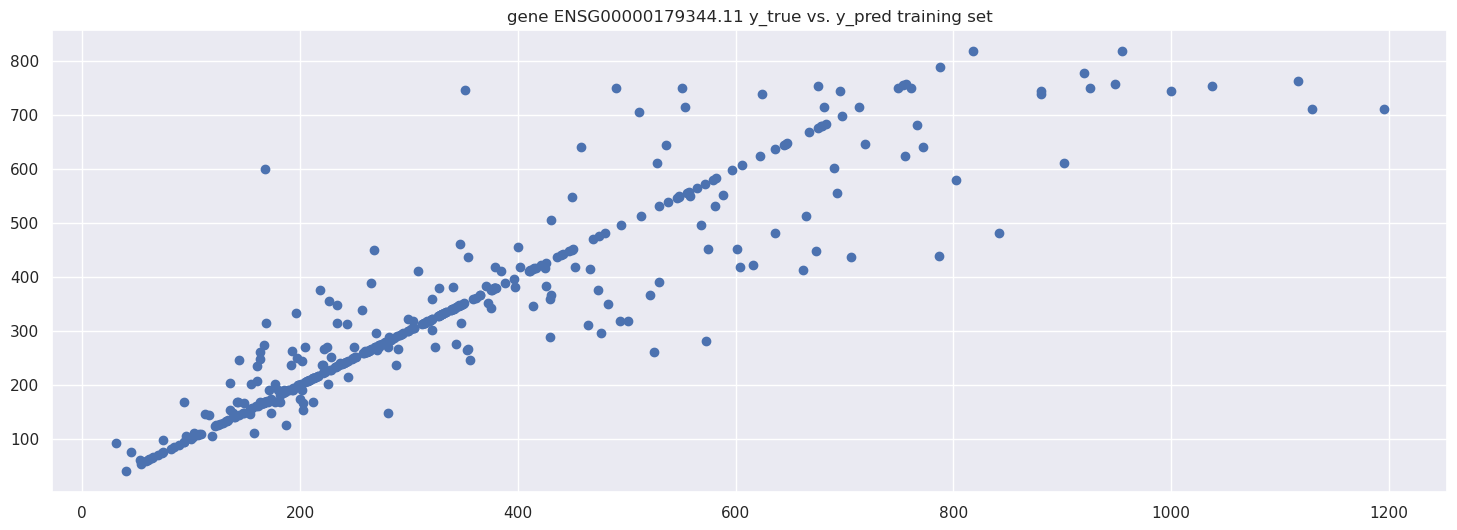

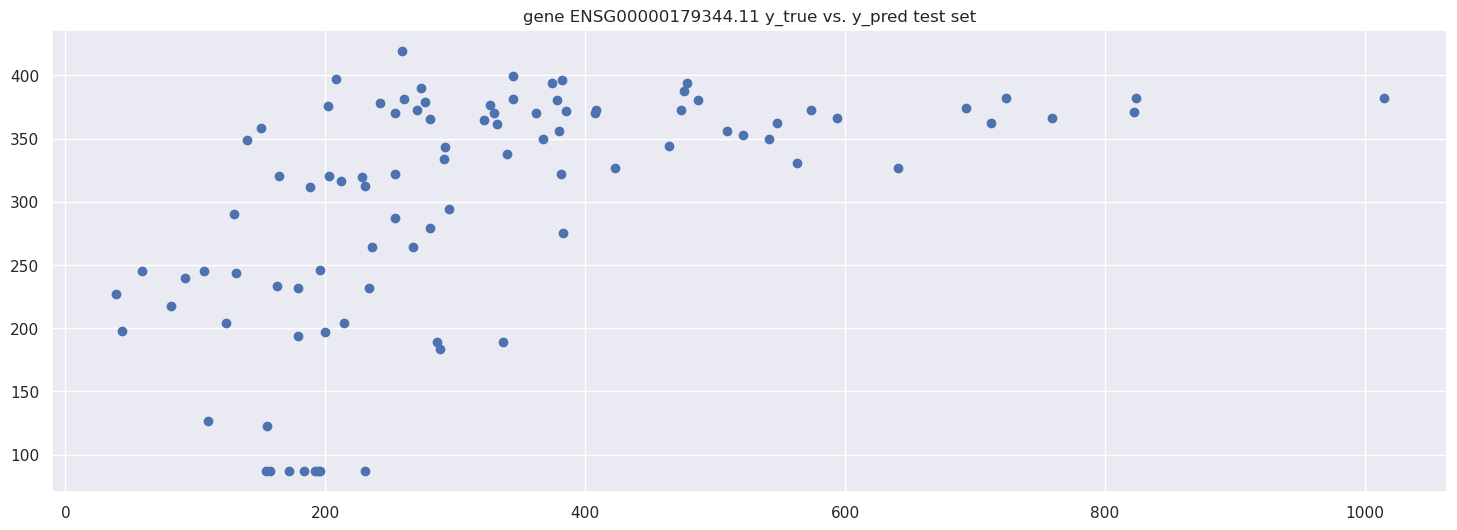

In [189]:
gene = data.gene_id.unique()[4]

# extract data
gene_df = data[data.gene_id == gene]
gene_df_train = gene_df[gene_df.test_set == False]
gene_df_test = gene_df[gene_df.test_set == True]
X_train = np.array(gene_df_train["embedding"].values.tolist())
X_test = np.array(gene_df_test["embedding"].values.tolist())
# Standard scale the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)
y_train = np.array(gene_df_train.expression)
y_test = np.array(gene_df_test.expression)


# param_dist = {"C": stats.expon(scale=100),
#               "epsilon": np.logspace(-5, 10, num=20),
#               "gamma": np.logspace(-5, 10, num=20)}
model = SVR(kernel="rbf", C=1000, epsilon=1e-1, gamma=1e-1)
model.fit(X_train, y_train)

# evaluate model on test set
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"train rvalue: {pearsonr(y_train, y_pred_train)[0]}")
print(f"test rvalue: {pearsonr(y_test, y_pred_test)[0]}")

# plot results on training set
plt.scatter(y_train, y_pred_train)
plt.title(f"gene {gene} y_true vs. y_pred training set")
plt.show()
plt.scatter(y_test, y_pred_test)
plt.title(f"gene {gene} y_true vs. y_pred test set")
plt.show()

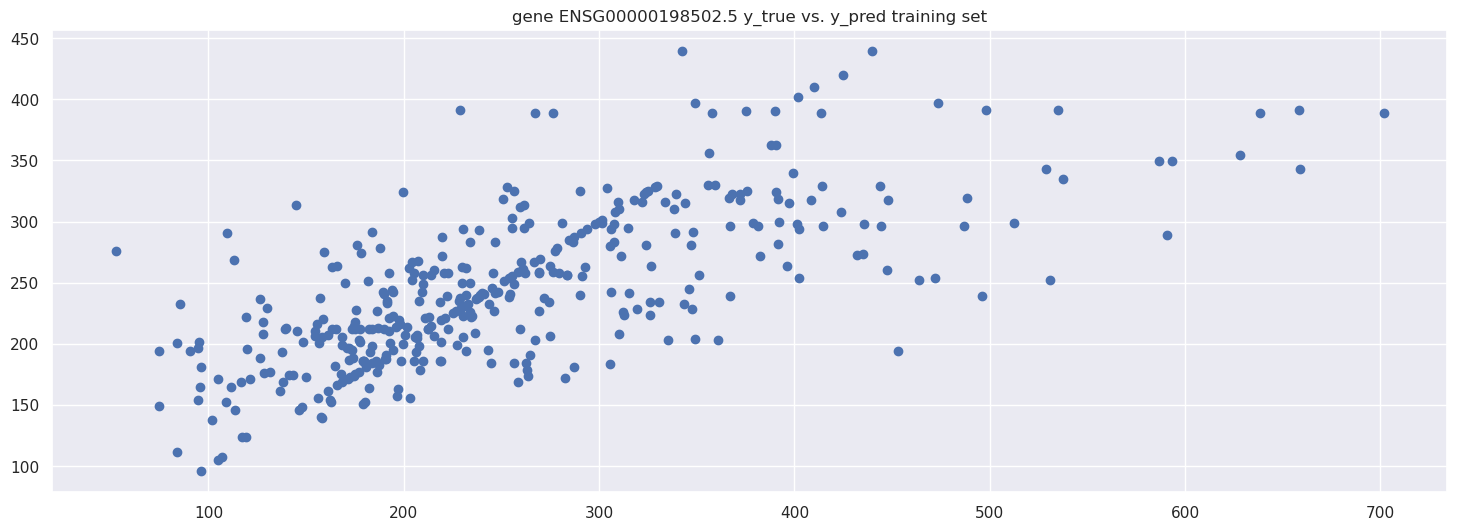

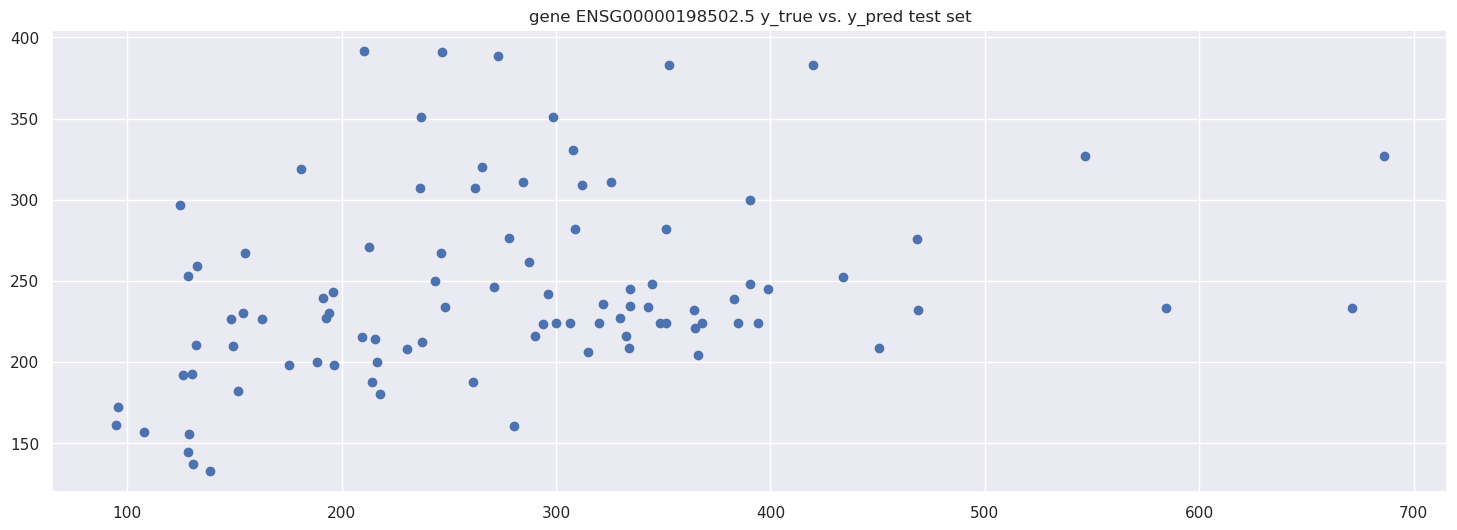

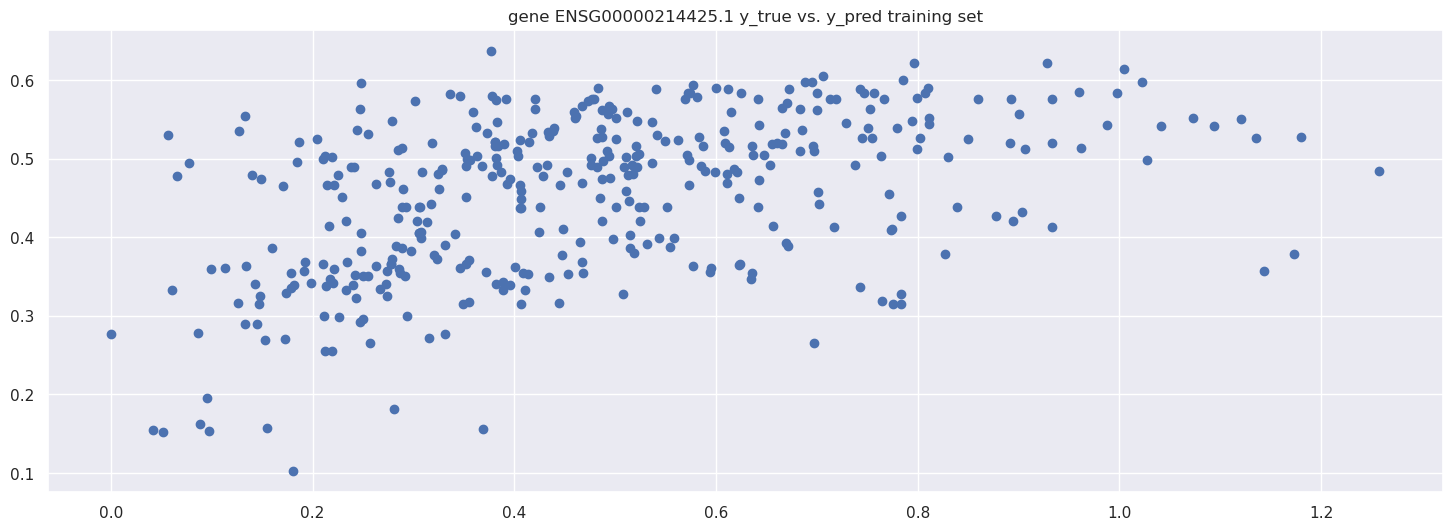

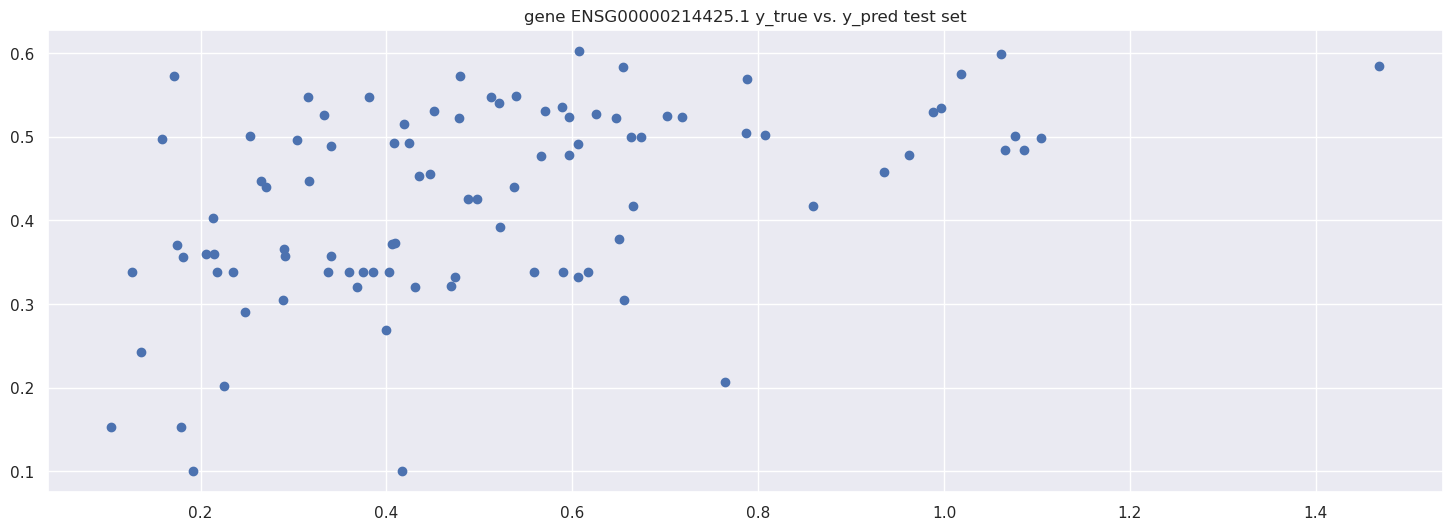

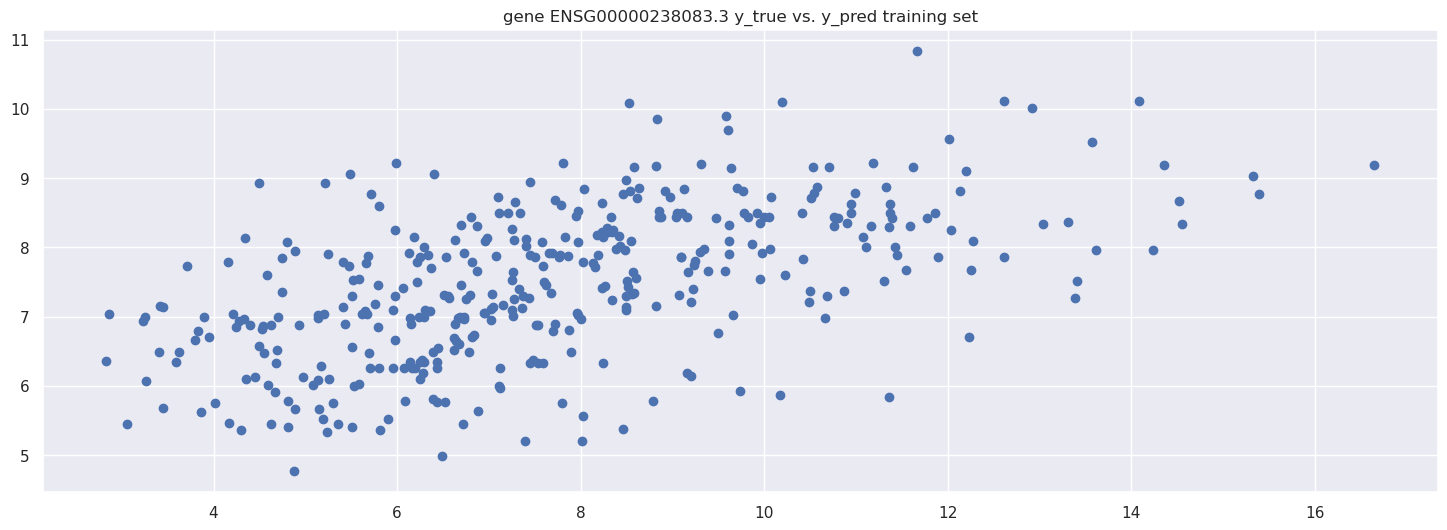

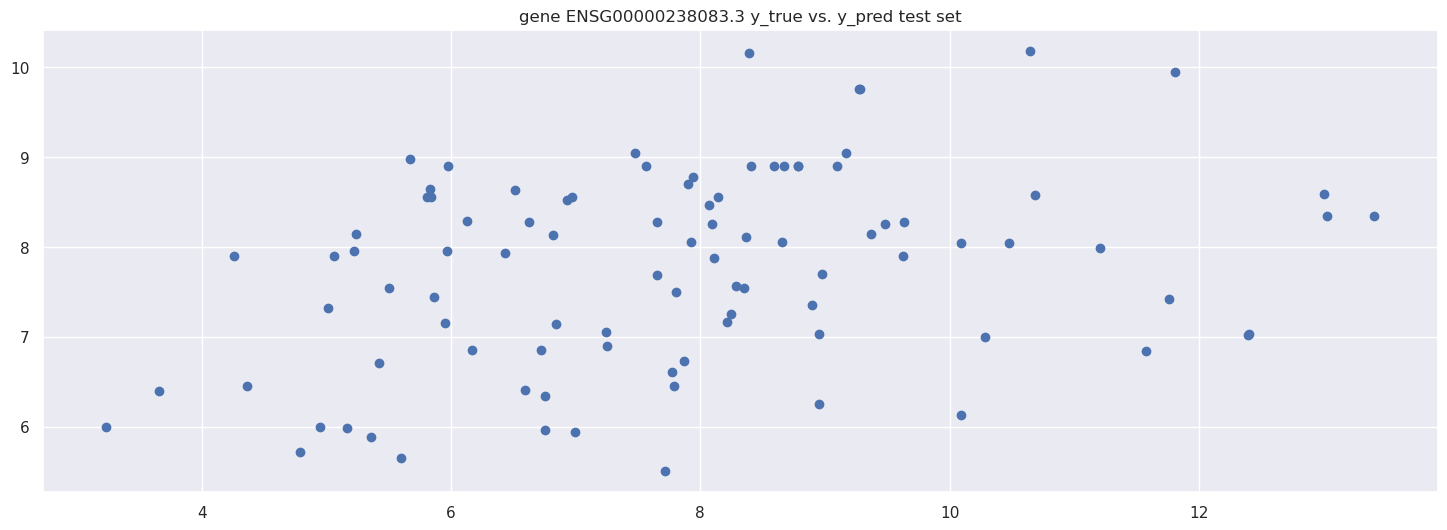

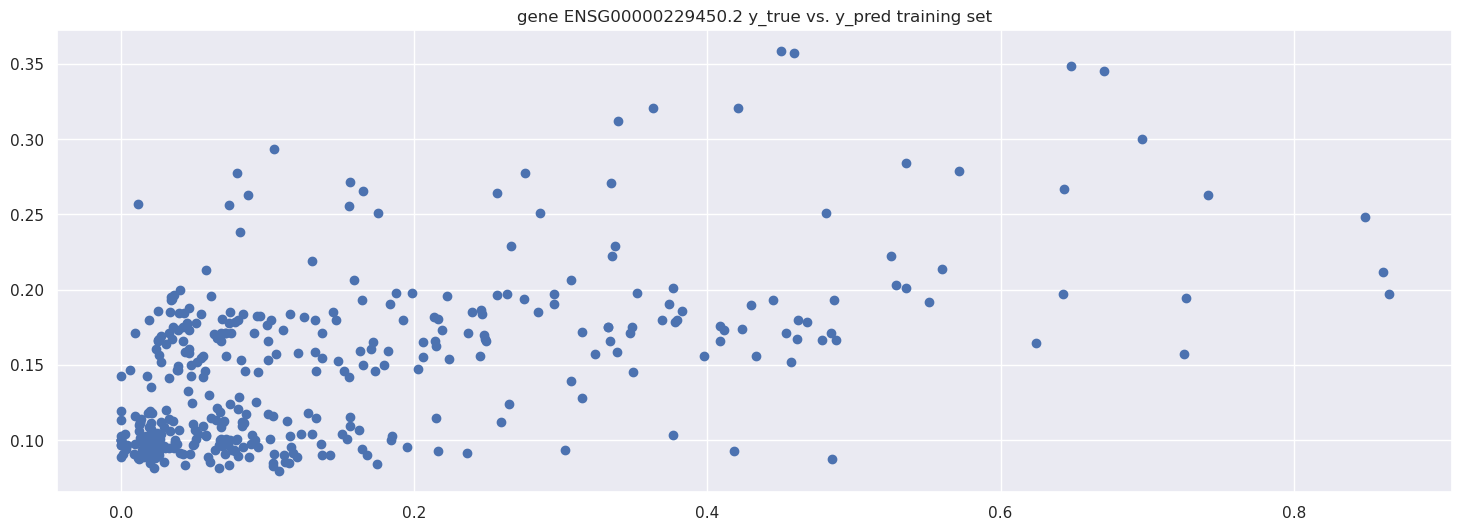

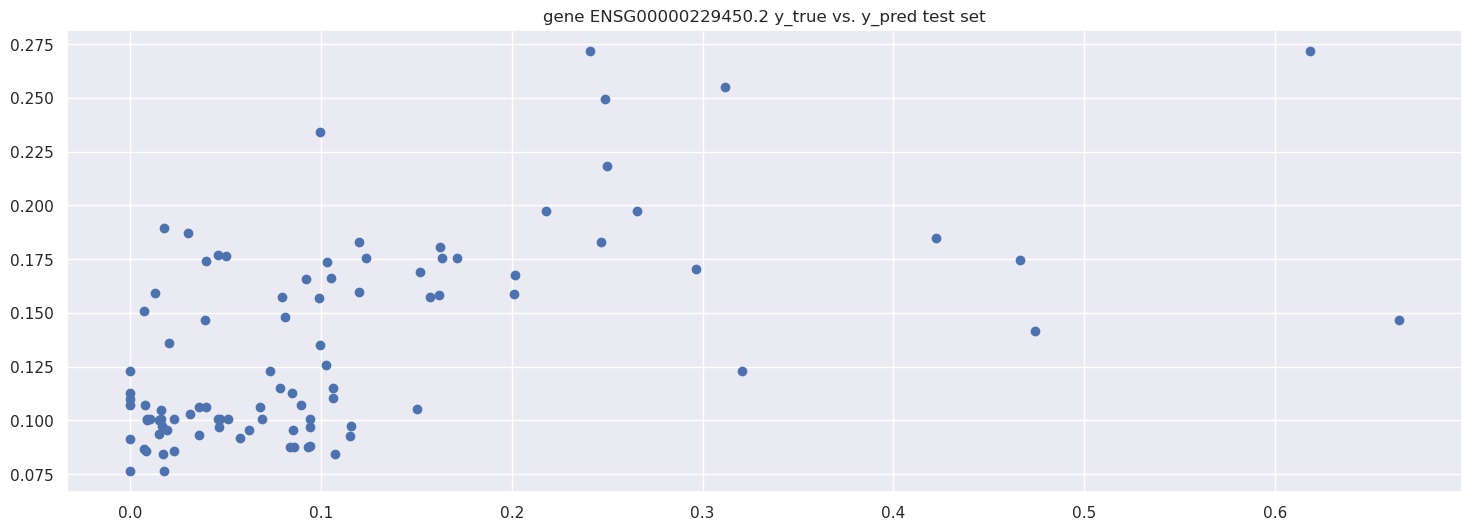

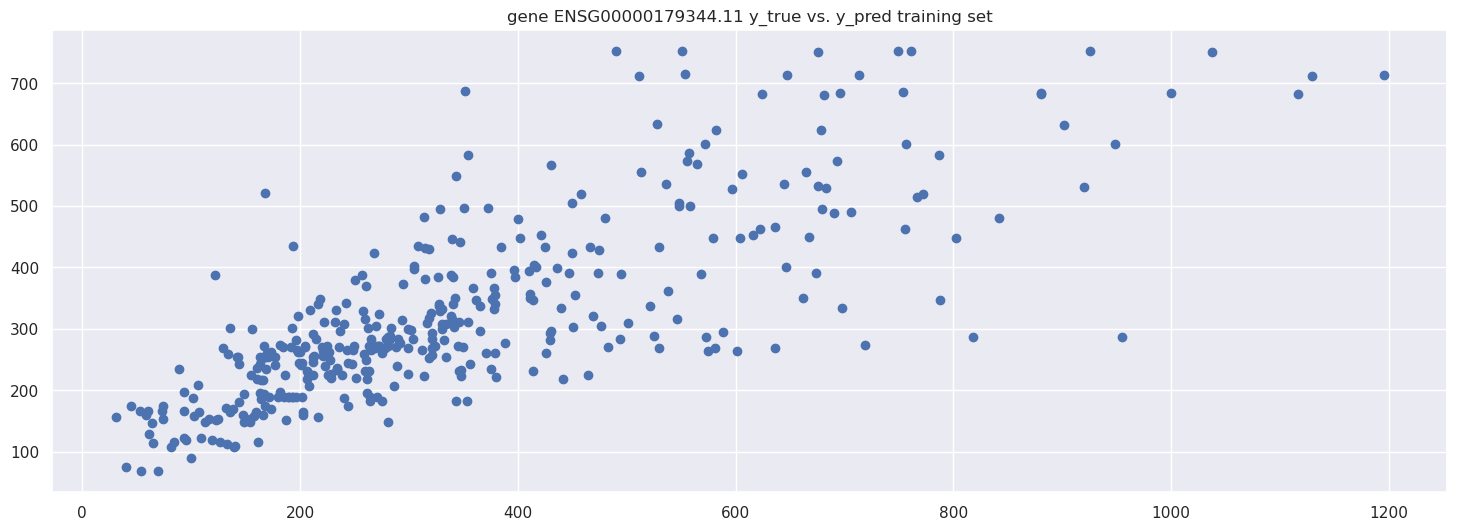

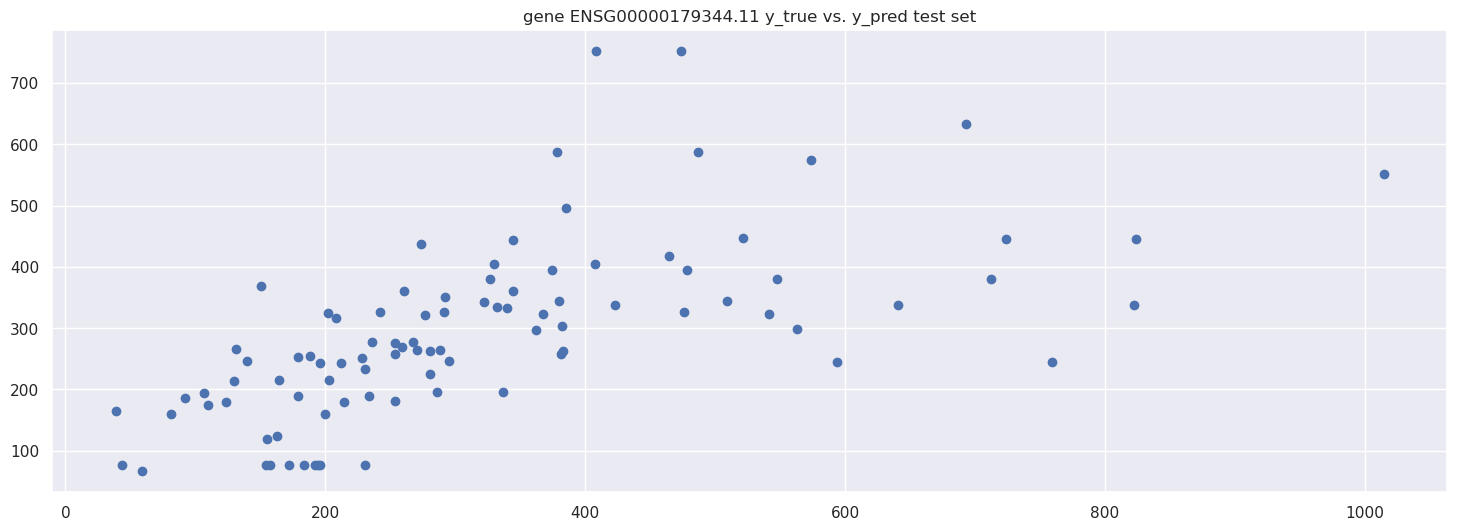

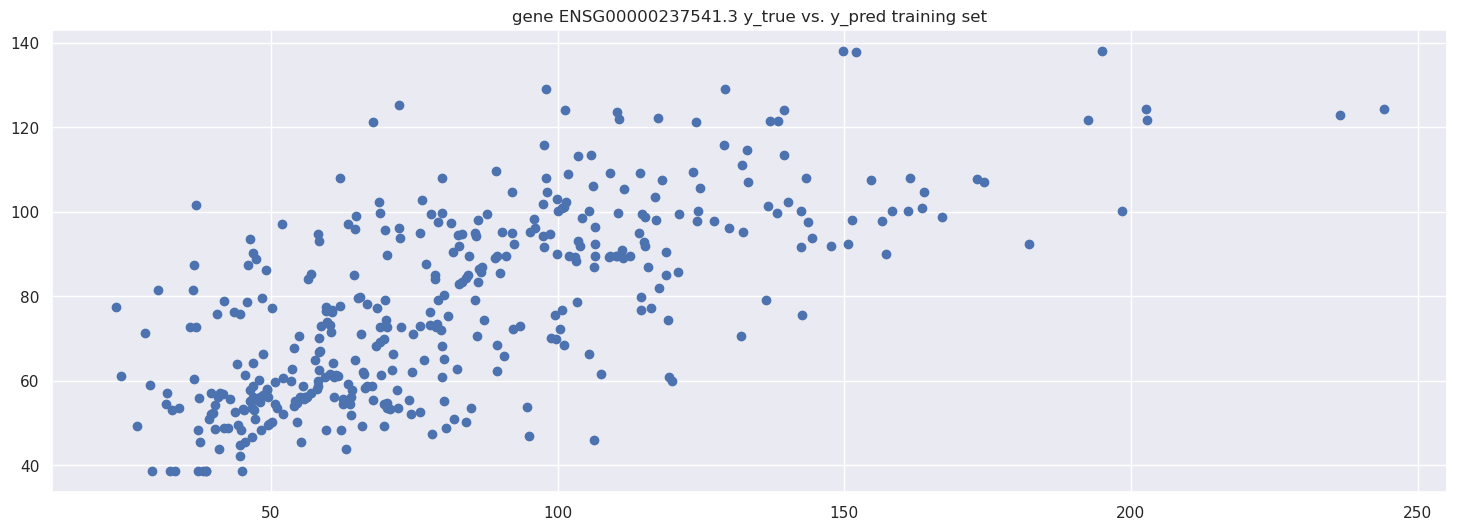

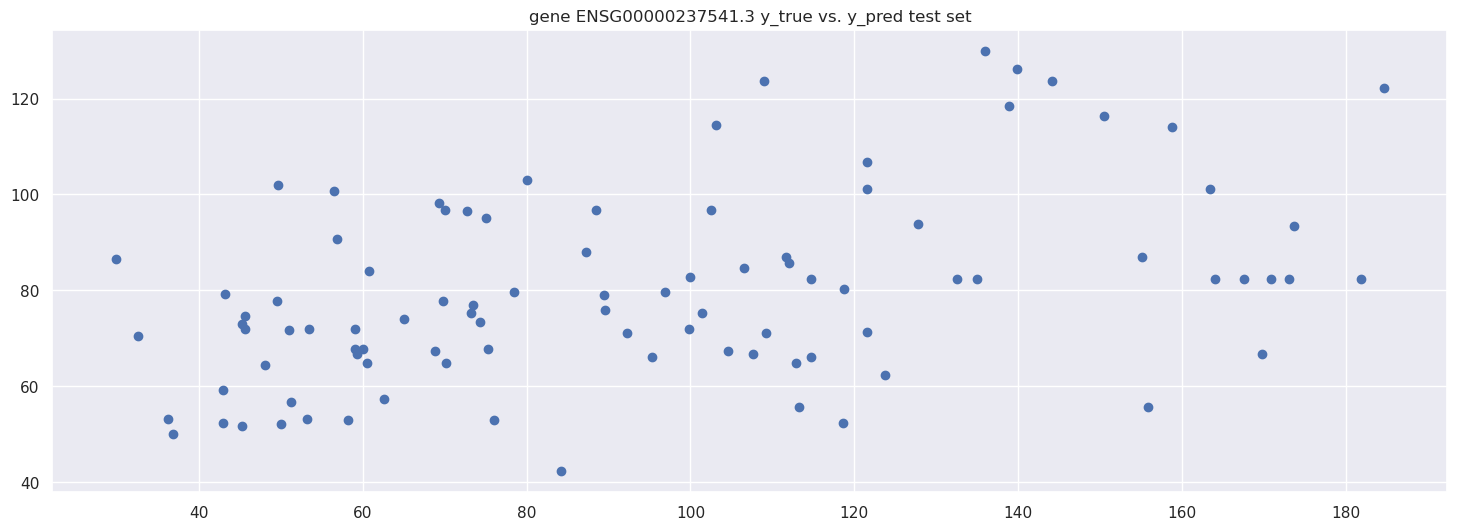

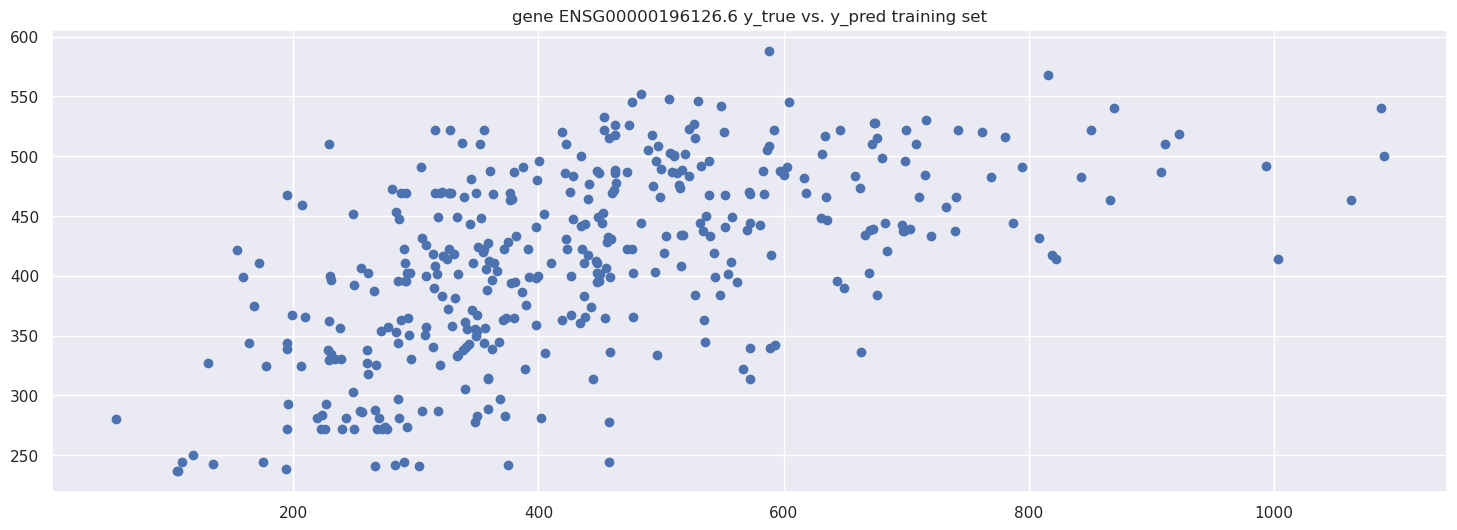

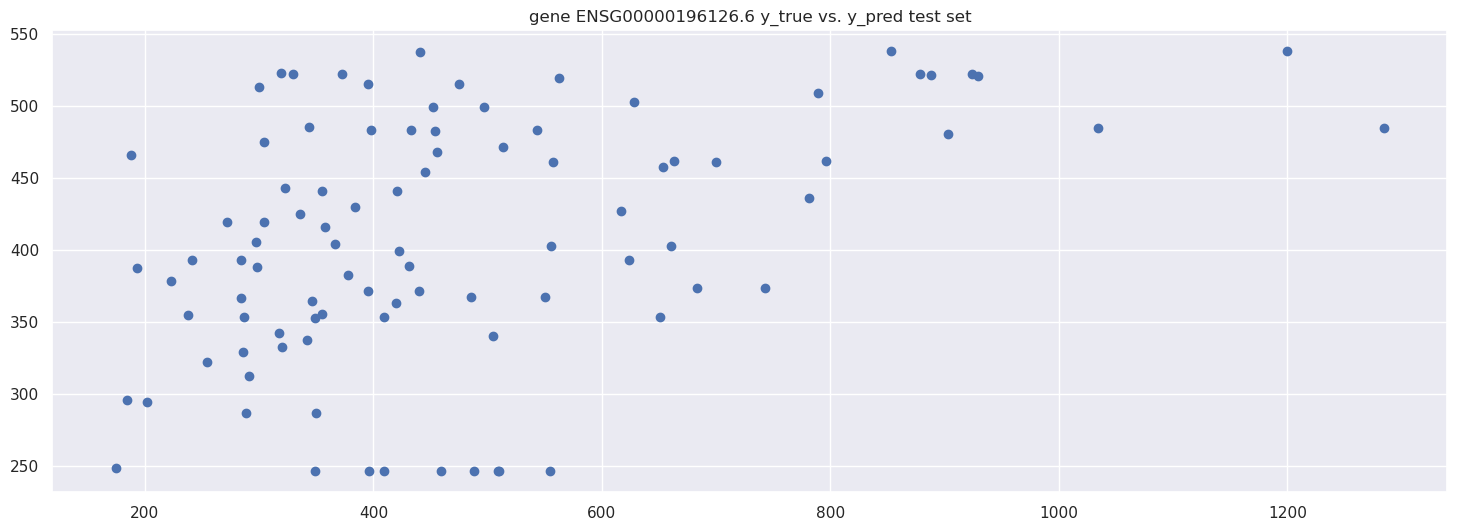

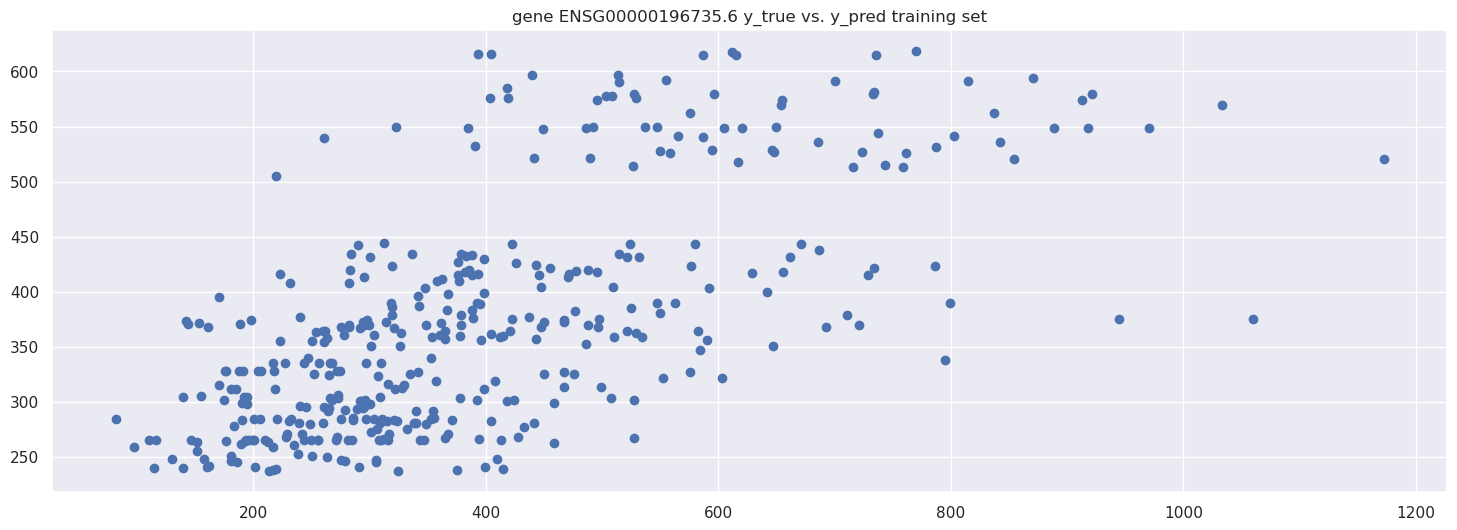

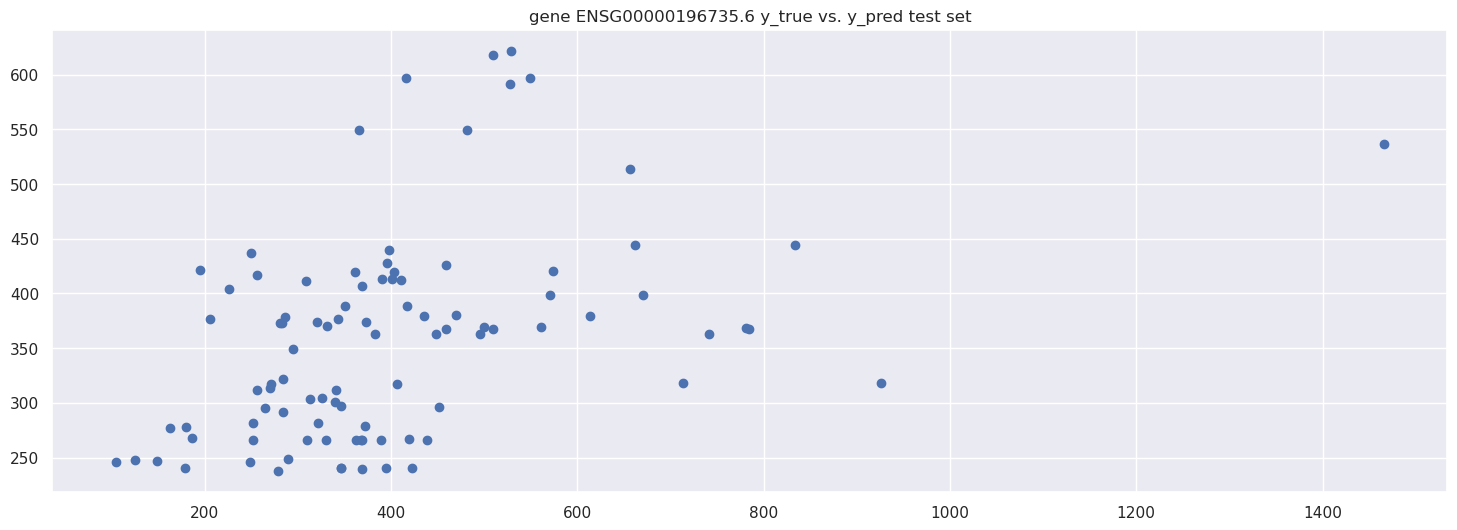

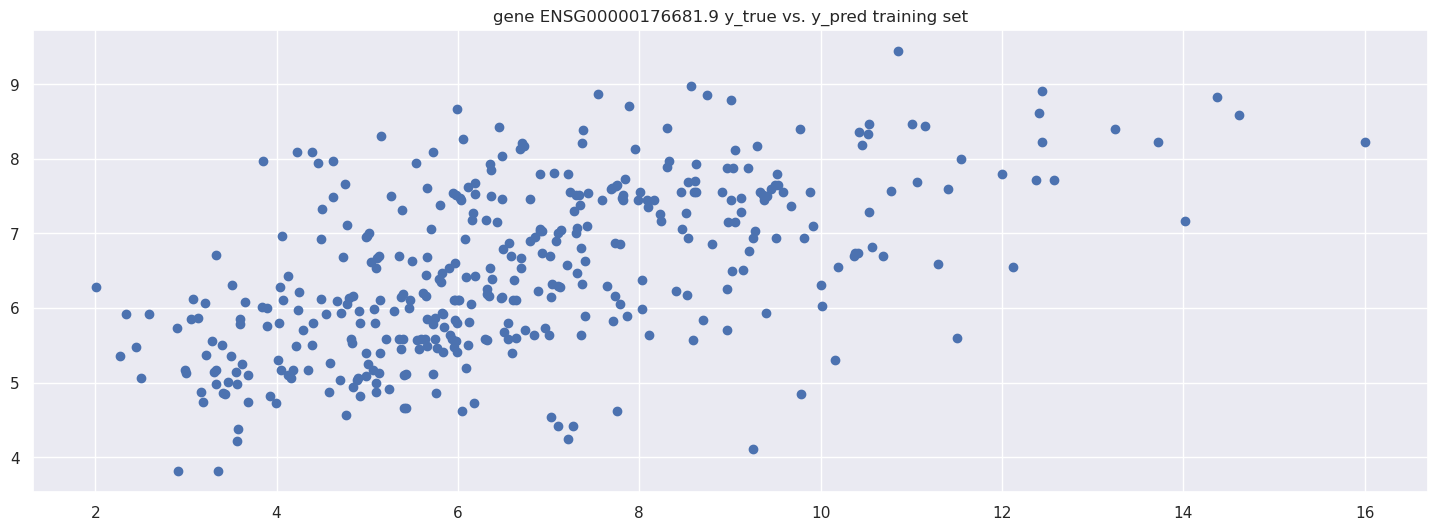

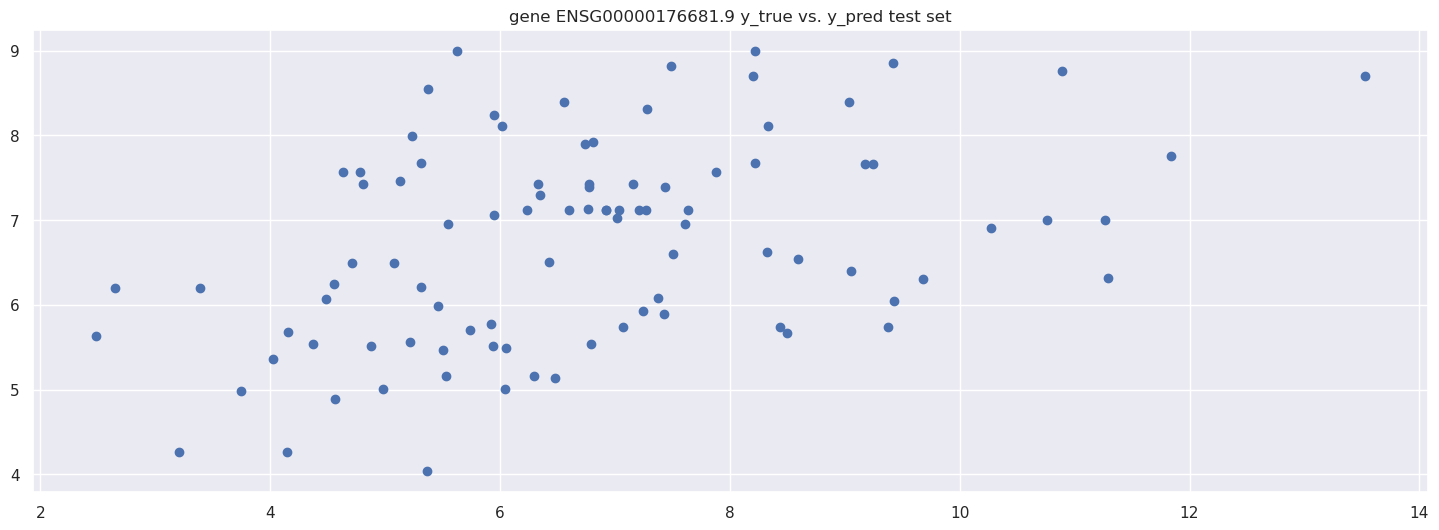

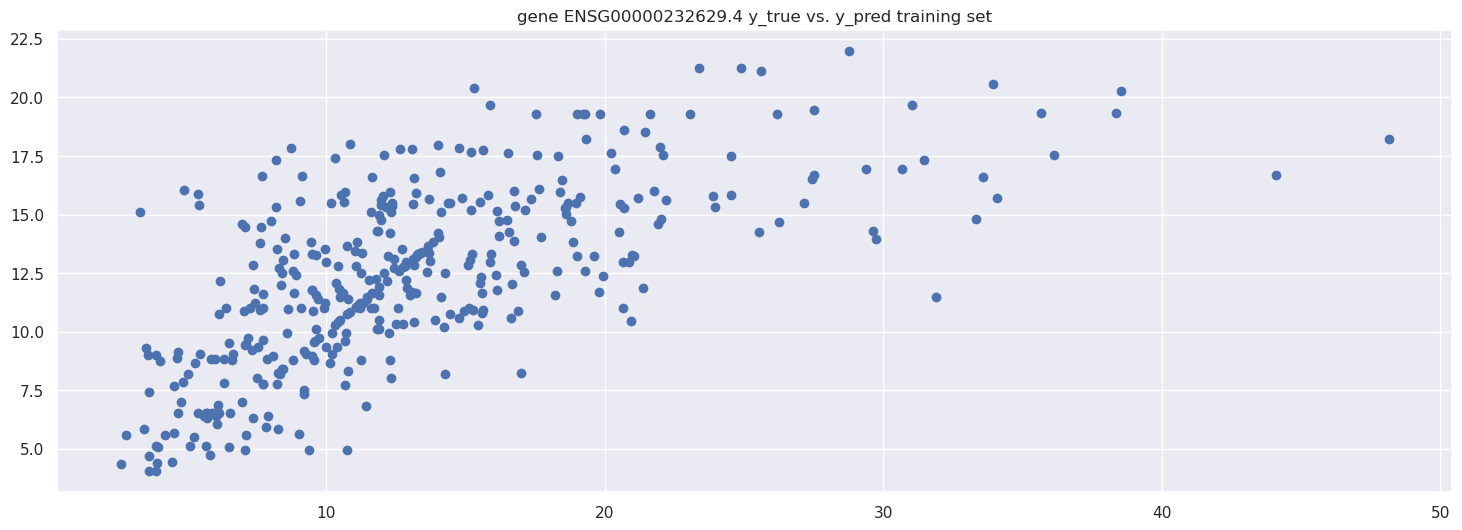

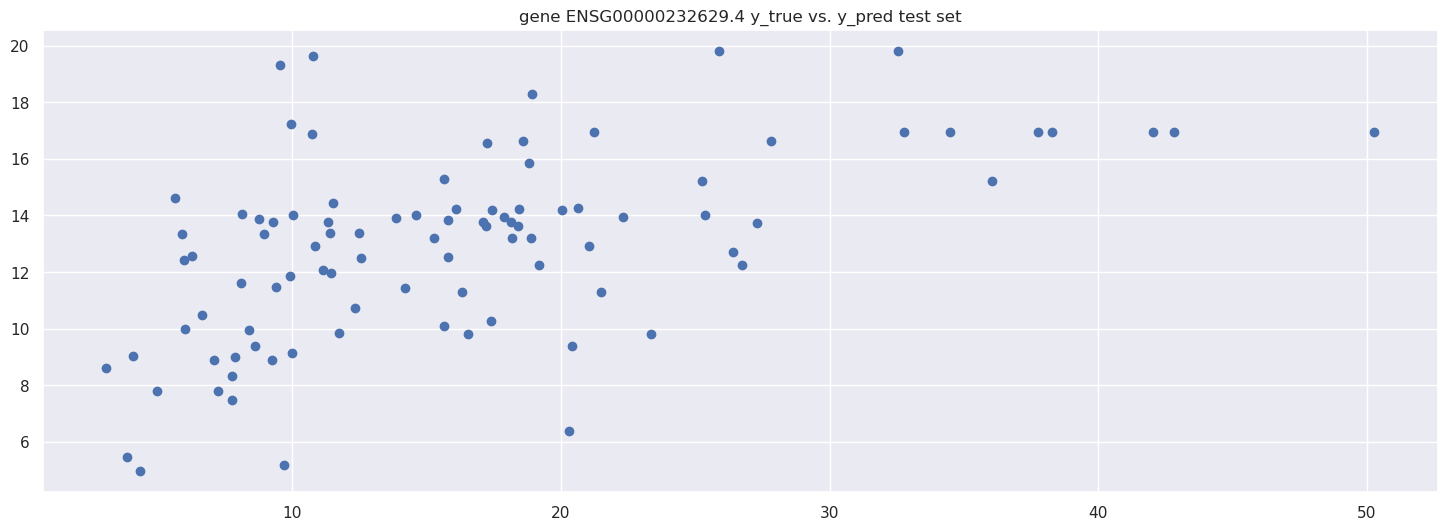

In [244]:
r_values_train = {}
r_values_test = {}
for gene in data.gene_id.unique():
    # extract data
    gene_df = data[data.gene_id == gene]
    gene_df_train = gene_df[gene_df.test_set == False]
    gene_df_test = gene_df[gene_df.test_set == True]
    X_train = np.array(gene_df_train["embedding"].values.tolist())
    X_test = np.array(gene_df_test["embedding"].values.tolist())
    # Standard scale the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    # scaler = StandardScaler().fit(X_test)
    X_test = scaler.transform(X_test)
    y_train = np.array(gene_df_train.expression)
    y_test = np.array(gene_df_test.expression)

    # train model using a random search
    param_dist = {"C": np.logspace(-5, 5, num=11),  # stats.expon(scale=100)
                  "epsilon": np.logspace(-5, -1, num=5),
                  "gamma": np.logspace(-5, -1, num=5)}
    random_search = RandomizedSearchCV(SVR(kernel="rbf"), param_distributions=param_dist, n_iter=100)
    random_search.fit(X_train, y_train)

    # evaluate model on test set
    y_pred_train = random_search.predict(X_train)
    y_pred_test = random_search.predict(X_test)
    r_values_train[gene] = pearsonr(y_train, y_pred_train)[0]
    r_values_test[gene] = pearsonr(y_test, y_pred_test)[0]

    # plot results on training set
    plt.scatter(y_train, y_pred_train)
    plt.title(f"gene {gene} y_true vs. y_pred training set")
    plt.show()
    plt.scatter(y_test, y_pred_test)
    plt.title(f"gene {gene} y_true vs. y_pred test set")
    plt.show()

In [245]:
r_values_train

{'ENSG00000198502.5': 0.7066011967216157,
 'ENSG00000214425.1': 0.4600626980666814,
 'ENSG00000238083.3': 0.5628103468072951,
 'ENSG00000229450.2': 0.5578359253126826,
 'ENSG00000179344.11': 0.7842375325274836,
 'ENSG00000237541.3': 0.7013742211866039,
 'ENSG00000196126.6': 0.564843492226887,
 'ENSG00000196735.6': 0.6630045660373063,
 'ENSG00000176681.9': 0.5685785964132054,
 'ENSG00000232629.4': 0.6637049462345745}

In [246]:
r_values_test

{'ENSG00000198502.5': 0.31260857312866586,
 'ENSG00000214425.1': 0.4786395851109123,
 'ENSG00000238083.3': 0.32299409559720027,
 'ENSG00000229450.2': 0.5640817670633341,
 'ENSG00000179344.11': 0.6248051126060075,
 'ENSG00000237541.3': 0.4409766710536942,
 'ENSG00000196126.6': 0.42684932383663127,
 'ENSG00000196735.6': 0.426746088738312,
 'ENSG00000176681.9': 0.41488240692280387,
 'ENSG00000232629.4': 0.5441809847878141}

In [247]:
results = [v for v in r_values_test.values()]
print(f"mean: {np.mean(results)}")
print(f"SD: {np.std(results)}")

mean: 0.4556764608845375
SD: 0.09504620274066358


In [184]:
train_df = pd.DataFrame({"gene_id": r_values_train.keys(), "r_values": r_values_train.values()})
test_df = pd.DataFrame({"gene_id": r_values_test.keys(), "r_values": r_values_test.values()})

# 3 Comparison to prediction based on single SNPs

In [24]:
reference = pd.read_csv(snp_reference_file, sep="\t")
reference = reference[reference.GENE_ID.isin(data.gene_id.unique())]
reference.GENE_ID = reference.GENE_ID.astype('category')
reference["abs_rvalue"] = np.abs(reference.rvalue.values)
reference.head()

,SNP_ID,ID,GENE_ID,PROBE_ID,CHR_SNP,CHR_GENE,SNPpos,TSSpos,distance,rvalue,pvalue,log10pvalue,abs_rvalue
55450,rs10020034,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120294331.0,120299287,4956.0,0.548974,1.079312e-30,29.966853,0.548974
55451,rs3955380,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120334410.0,120299287,35123.0,0.547157,1.832933e-30,29.736854,0.547157
55452,rs28403131,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120285806.0,120299287,13481.0,0.545653,2.834881e-30,29.547465,0.545653
55453,rs79262354,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120338335.0,120299287,39048.0,0.545126,3.300820e-30,29.481378,0.545126
55454,rs78958430,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120338339.0,120299287,39052.0,0.544934,3.488677e-30,29.457339,0.544934


In [196]:
median_expr_per_gene = pd.DataFrame(expression.groupby("Gene_Symbol")["expression"].median())
median_expr_per_gene = median_expr_per_gene.reset_index()

In [234]:
gene_order = median_expr_per_gene.sort_values(by="expression")["Gene_Symbol"].to_list()

reference.GENE_ID = reference.GENE_ID.cat.set_categories(gene_order)
train_df.gene_id = train_df.gene_id.astype("category")
train_df.gene_id = train_df.gene_id.cat.set_categories(gene_order)
test_df.gene_id = test_df.gene_id.astype("category")
test_df.gene_id = test_df.gene_id.cat.set_categories(gene_order)
median_expr_per_gene.Gene_Symbol = median_expr_per_gene.Gene_Symbol.astype("category")
median_expr_per_gene.Gene_Symbol = median_expr_per_gene.Gene_Symbol.cat.set_categories(gene_order)

reference = reference.sort_values(by = 'GENE_ID')
train_df = train_df.sort_values(by = 'gene_id')
test_df = test_df.sort_values(by = 'gene_id')
median_expr_per_gene = median_expr_per_gene.sort_values(by = "Gene_Symbol")

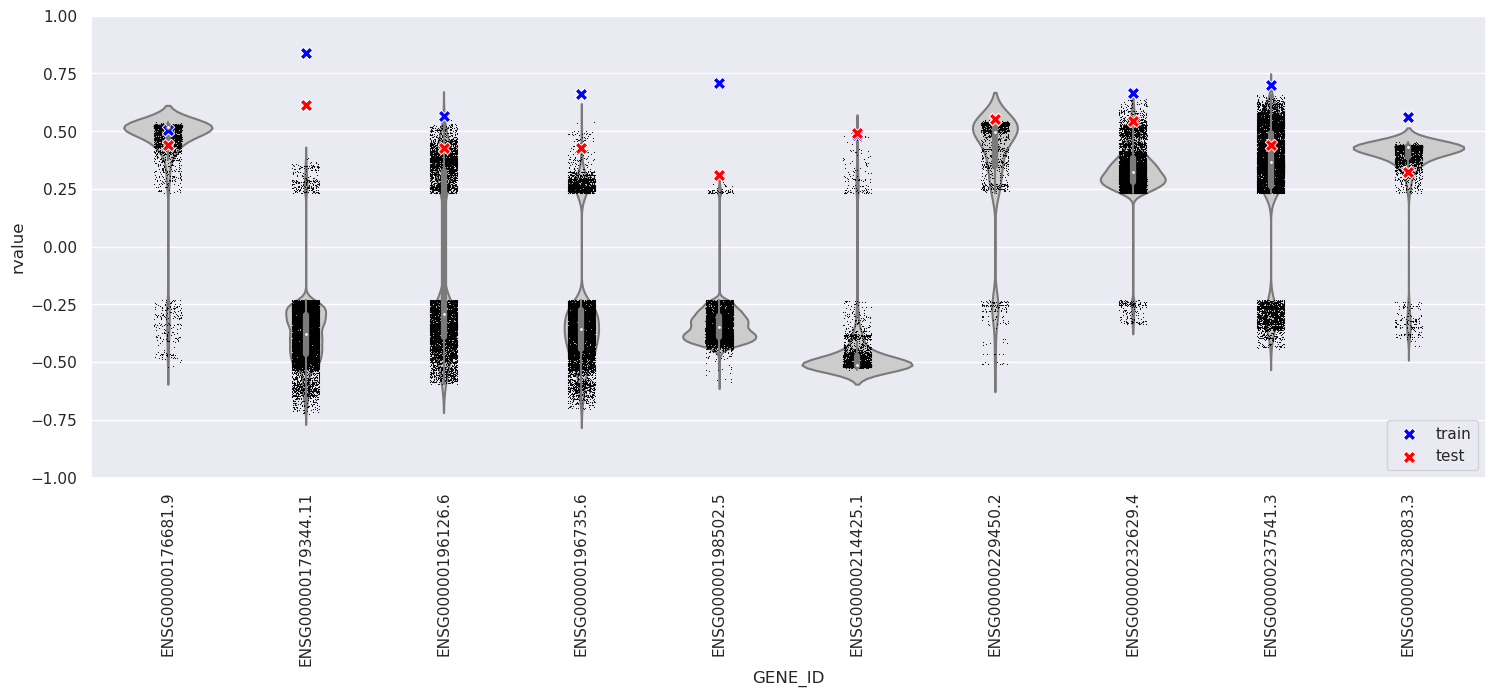

In [235]:
sns.set(rc={'figure.figsize':(18,6)})

sns.violinplot(x = "GENE_ID", y ="rvalue", data=reference, color="0.8", zorder=0)
sns.stripplot(x = "GENE_ID", y ="rvalue", data=reference, color="0.0", size=0.8, zorder=1) 
sns.scatterplot(x = "gene_id", y="r_values", data=train_df, color="blue", s=80, marker="X", zorder=2, label="train")
sns.scatterplot(x = "gene_id", y="r_values", data=test_df, color="red", s=80, marker="X", zorder=3, label="test")

plt.ylim(-1.0, 1.0)
plt.xticks(rotation = 90)
plt.legend(loc='lower right')
plt.show()

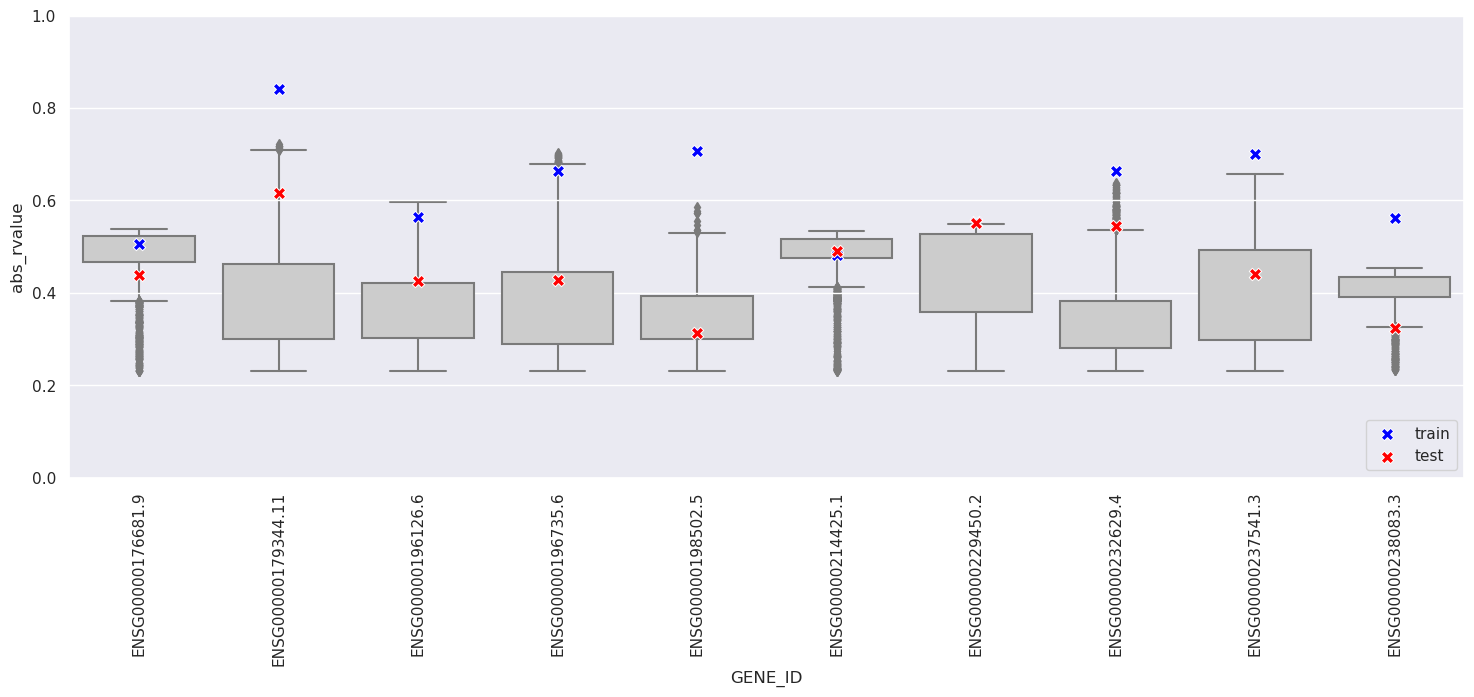

In [236]:
sns.boxplot(x = "GENE_ID", y ="abs_rvalue", data=reference, color="0.8", zorder=0) 
sns.scatterplot(x = "gene_id", y="r_values", data=train_df, color="blue", s=80, marker="X", zorder=1, label="train")
sns.scatterplot(x = "gene_id", y="r_values", data=test_df, color="red", s=80, marker="X", zorder=2, label="test")

plt.ylim(0.0, 1.0)
plt.xticks(rotation = 90)
plt.legend(loc='lower right')
plt.show()

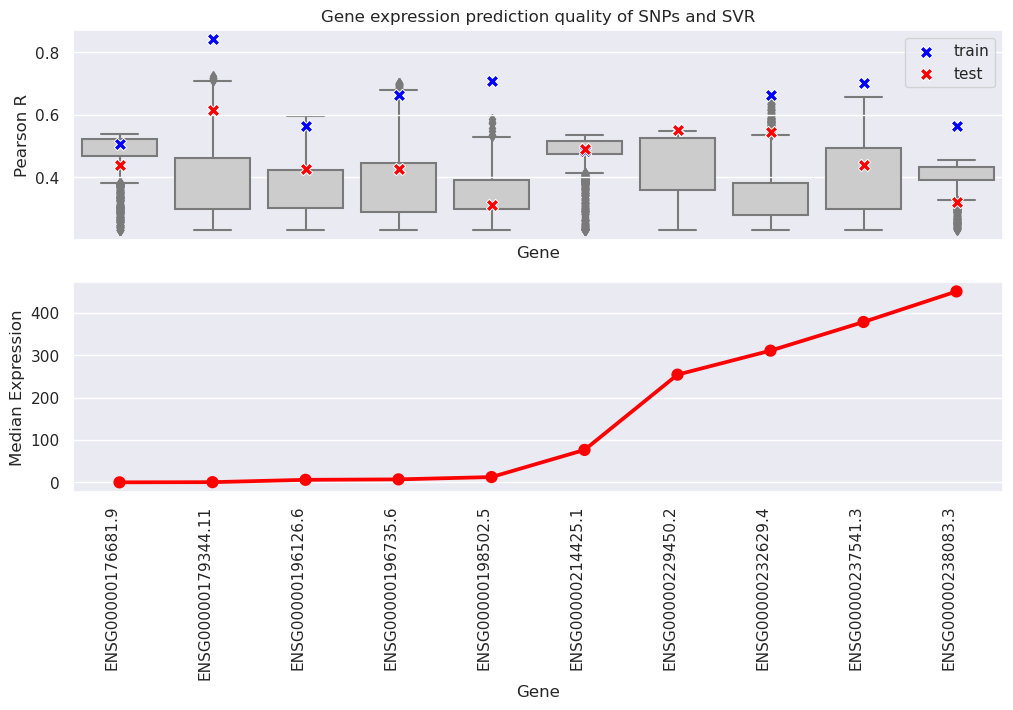

In [238]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

ax1.set_title("Gene expression prediction quality of SNPs and SVR")

sns.boxplot(x = "GENE_ID", y ="abs_rvalue", data=reference, color="0.8", zorder=0, ax=ax1) 
sns.scatterplot(x = "gene_id", y="r_values", data=train_df, color="blue", s=80, marker="X", zorder=1, label="train", ax=ax1)
sns.scatterplot(x = "gene_id", y="r_values", data=test_df, color="red", s=80, marker="X", zorder=2, label="test", ax=ax1)
# plt.ylim(0.0, 1.0)
ax1.set_xlabel("Gene")
ax1.set_ylabel("Pearson R")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')

sns.pointplot(data=median_expr_per_gene, x="Gene_Symbol", y="expression", color="red", ax=ax2)
ax2.set_ylabel("Median Expression")
ax2.set_xlabel("Gene")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()